# Fiddler working notebook for Churn usecase



1. Connect to Fiddler
2. Upload a baseline dataset
3. Add your model with Fiddler and create a surrogate model
4. Publish production events
5. Run prediction and explanation on a sample data point

## 0. Imports

In [50]:
!pip3 install -q fiddler-client==1.4.0;

import numpy as np
import pandas as pd
import fiddler as fdl
import sklearn
import time

print(f"Running client version {fdl.__version__}")

Running client version 1.4.0


In [14]:
RANDOM_STATE = 42

## 1. Connect to Fiddler

In [65]:
url = 'https://csteam.dev.fiddler.ai/'
token = 'yXtp73iJFPrFXfjxVutT_RC-VERh198N4hSNd0lWex0'
org_id = 'csteam'

client = fdl.FiddlerApi(
    url=url,
    org_id=org_id,
    auth_token=token
)

In [66]:
PROJECT_ID = 'imbalance_credit_card_fraud'

In [67]:
MODEL_ID = 'imbalance_cc_fraud'
DATASET_ID = 'imbalance_cc_fraud_baseline'

In [70]:
client.create_project(PROJECT_ID)

{'project_name': 'imbalance_credit_card_fraud'}

## 2. Upload a baseline dataset


In [103]:
PATH_TO_BASELINE_CSV = 'https://s3.us-west-1.amazonaws.com/fiddler.ai/download/imbalance_data/imbalance_baseline_data_sample.csv'

baseline_df = pd.read_csv(PATH_TO_BASELINE_CSV)
baseline_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,prediction_score,Class
0,-0.095717,-0.181205,1.186638,0.174374,0.192811,1.283202,0.085843,0.100202,0.068697,0.012306,...,-0.130185,-0.149293,-0.130386,-0.417261,0.727474,-0.282047,0.038151,0.012069,0.00,0
1,-0.167680,-0.177481,1.338086,-0.262908,-1.224386,-1.229997,1.879685,3.131865,-0.616145,0.769305,...,-0.143104,-0.551317,-0.007326,1.067888,0.410250,0.994295,-0.081192,-0.001858,0.00,0
2,-0.182212,-0.843161,-0.771166,1.397387,1.472145,0.065873,0.057350,-0.736374,0.687517,-0.192999,...,-0.470332,-0.781973,0.021033,0.401564,-0.175494,-0.013405,0.262646,-0.015297,0.00,0
3,-0.143506,0.579824,-0.753790,-0.004463,-0.227110,-2.410126,0.327045,-1.134313,0.105330,0.100710,...,0.039473,0.187384,0.447314,0.752543,-2.317540,-0.287516,-0.016333,0.175144,0.00,0
4,-0.293440,-0.417909,0.079154,1.237330,0.263247,1.191461,0.357007,-0.837919,0.659904,-0.102563,...,0.191355,0.628542,0.105825,0.279335,-1.079106,-0.466951,0.113149,0.206482,0.01,0


In [98]:
baseline_df['Class'].value_counts()

0    22749
1       35
Name: Class, dtype: int64

In [99]:
print('Percentage of minority class: {}%'.format(round(baseline_df['Class'].value_counts()[1]*100/baseline_df.shape[0], 4)))


Percentage of minority class: 0.1536%


In [100]:
dataset_info = fdl.DatasetInfo.from_dataframe(baseline_df, max_inferred_cardinality=100)
dataset_info

,column,dtype,count(possible_values),is_nullable,value_range
0,scaled_amount,FLOAT,,False,-0.31 - 165.9
1,scaled_time,FLOAT,,False,-0.99 - 1.035
2,V1,FLOAT,,False,-36.5 - 2.447
3,V2,FLOAT,,False,-40.9 - 10.59
4,V3,FLOAT,,False,-18.3 - 3.803
5,V4,FLOAT,,False,-5.6 - 11.47
6,V5,FLOAT,,False,-29.7 - 29.16
7,V6,FLOAT,,False,-20.4 - 21.31
8,V7,FLOAT,,False,-20.9 - 31.53
9,V8,FLOAT,,False,-30.9 - 9.7


In [87]:
client.upload_dataset(
    project_id=PROJECT_ID,
    dataset_id=DATASET_ID,
    dataset={
        'baseline': baseline_df
    },
    info=dataset_info
)

{'uuid': '8fb48cde-34fe-436b-9cbb-1bec550fa860',
 'name': 'Ingestion dataset Upload',
 'info': {'project_name': 'imbalance_credit_card_fraud',
  'resource_name': 'imbalance_cc_fraud_baseline',
  'resource_type': 'DATASET'},
 'status': 'SUCCESS',
 'progress': 100.0,
 'error_message': None}

## 3. Add your model and create a surrogate model


In [101]:
CLASS_WEIGHT = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(baseline_df['Class']), y=baseline_df['Class']).tolist()
print(f'Computed class-weights: {CLASS_WEIGHT}')

Computed class-weights: [0.5007692645830586, 325.48571428571427]


Now, we will add two models - 
1. With class weight parameters
2. Without class weight parameters

In [89]:
BINARY_THRESHOLD = 0.4
TARGET_COL = 'Class'
OUTPUT_COL = 'prediction_score'

Below, we first create a `ModelInfo` object and then add the two models.

In [90]:
for mid in [MODEL_ID + '_weighted', MODEL_ID]:
    if 'weighted' in mid:
        weighting_params = fdl.core_objects.WeightingParams(class_weight=CLASS_WEIGHT)
        print(f'Registering model with weighting parameters.')
    else:
        weighting_params = None
        print(f'Registering model without weighting parameters.')
    target_col = TARGET_COL
    output_col = OUTPUT_COL
    inp_features = set(baseline_df.columns) - set([target_col, output_col])
    
    # Create ModelInfo object
    model_info = fdl.ModelInfo.from_dataset_info(
        dataset_info=dataset_info,
        target=target_col,
        dataset_id= DATASET_ID,
        features=inp_features,
        display_name='Fraud model',
        description='Fraud model with predictions in baseline',
        input_type=fdl.core_objects.ModelInputType.TABULAR,
        model_task=fdl.core_objects.ModelTask.BINARY_CLASSIFICATION,
        outputs=output_col,
        weighting_params=weighting_params,
        binary_classification_threshold=BINARY_THRESHOLD,
        categorical_target_class_details=[0, 1],

    )
    
    # Add Model and create surrogate model
    if mid not in client.list_models(project_id=PROJECT_ID):
        client.add_model(project_id=PROJECT_ID, model_id=mid, dataset_id=DATASET_ID, model_info=model_info)
        client.add_model_surrogate(project_id=PROJECT_ID, model_id=mid)
    else:
        print(f'Model: {mid} already exists in Project: {PROJECT_ID}')



Registering model with weighting parameters.


<ipython-input-90-614829f40aa4>:30: DeprecationWarning: Call to deprecated method list_models. (Please use get_models, this method will be removed in future versions)
  if mid not in client.list_models(project_id=PROJECT_ID):


Validating model info...
Generating surrogate model...
Testing the deployed model with sample events...
Dataset already has output columns; predictions already imported...
Beginning to precache for dataset imbalance_cc_fraud_baseline with model imbalance_cc_fraud_weighted...

--- Beginning Impact/Importance Caching ---

 |██████████████████████████████████████████████████| 100.0% Global Features Cached
--- Finished Impact/Importance Caching ---

Successfully precached for dataset imbalance_cc_fraud_baseline with model imbalance_cc_fraud_weighted
Pre-caching completed 
Start initialize monitoring
Init monitoring succeeded:JOB UUID: d3eebe75-7b2e-4774-a78b-1c32e07665d4 task id: 8c2e1a0f-4fcb-42bc-aeff-83c6f3dbbac0 result: {'result': 'SKETCH GENERATION RESULTS: \nNo event-weighted HISTOGRAM sketch generated, which is only applicable for data with class imbalance.\n No event-weighted FREQUENCY sketch generated, which is only applicable for data with class imbalance.\n No event-weighted NUL

## 4. Publish production events

In [107]:
PATH_TO_EVENTS_CSV = 'https://s3.us-west-1.amazonaws.com/fiddler.ai/download/imbalance_data/imbalance_production_data.csv'

production_df = pd.read_csv(PATH_TO_EVENTS_CSV)
production_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V22,V23,V24,V25,V26,V27,V28,prediction_score,Class,timestamp
0,-0.293440,-0.028231,-1.464897,1.975528,-1.077145,2.819191,0.069850,-0.789044,-1.196101,0.673654,...,-0.272505,-0.031549,-0.406166,0.157769,-0.104393,0.073796,-0.041570,0.58,1,2022-09-14 20:10:36
1,3.030811,-0.145267,-4.198735,0.194121,-3.917586,3.920748,-1.875486,-2.118933,-3.614445,1.687884,...,-0.183001,-0.440387,0.292539,-0.144967,-0.251744,1.249414,-0.131525,0.93,1,2022-09-10 07:58:22
2,0.996996,0.514891,-4.599447,2.762540,-4.656530,5.201403,-2.470388,-0.357618,-3.767189,0.061466,...,0.261333,0.621415,0.994110,-0.687853,-0.337531,-1.612791,1.231425,0.62,1,2022-09-01 20:10:43
3,-0.275554,0.195268,-25.825982,19.167239,-25.390229,11.125435,-16.682644,3.933699,-37.060311,-28.759799,...,5.703684,3.510019,0.054330,-0.671983,-0.209431,-4.950022,-0.448413,0.87,1,2022-07-21 03:56:35
4,5.899113,-0.325016,-2.335655,2.225380,-3.379450,2.178538,-3.568264,0.316814,-1.734948,1.449139,...,0.297412,0.308536,-0.598416,-0.121850,-0.491018,0.701606,0.206966,0.97,1,2022-07-01 21:02:08


In [92]:
print('Percentage of minority class: {}%'.format(round(production_df['Class'].value_counts()[1]*100/production_df.shape[0], 4)))


Percentage of minority class: 0.5144%


We see that the percentage of minority class in production data is > 3 times than that of baseline data. This should create a big drift in the predictions

We will now publish the same production data for both the model, i.e. with class weights and without class weights

In [93]:
for mid in [MODEL_ID + '_weighted', MODEL_ID]:
    t0 = time.time()
    print('Publishing events for Model ID: {}'.format(mid))
    client.publish_events_batch(
        project_id=PROJECT_ID,
        model_id=mid,
        batch_source=production_df,
        timestamp_field='timestamp'
    )
    t1 = time.time()
    dt = t1-t0
    print(f'Time required: {dt} secs for {len(production_df)} events. [{len(production_df)/dt} events/sec]')

Publishing events...
Time required: 45.525489807128906 secs for 57158 events. [1255.5164204087166 events/sec]
Publishing events...
Time required: 30.10324001312256 secs for 57158 events. [1898.7324944120226 events/sec]


## 5. Get insights

**You're all done!**

Run the following code block to get your URL.

In [ ]:
print('/'.join([URL, 'projects', PROJECT_ID, 'models', MODEL_ID, 'monitor']))

*Please allow 3-5 minutes for monitoring data to populate the charts.*

## 6. Monitoring Output

We see if we do not declare class weights the drift is low (`<=0.05`)

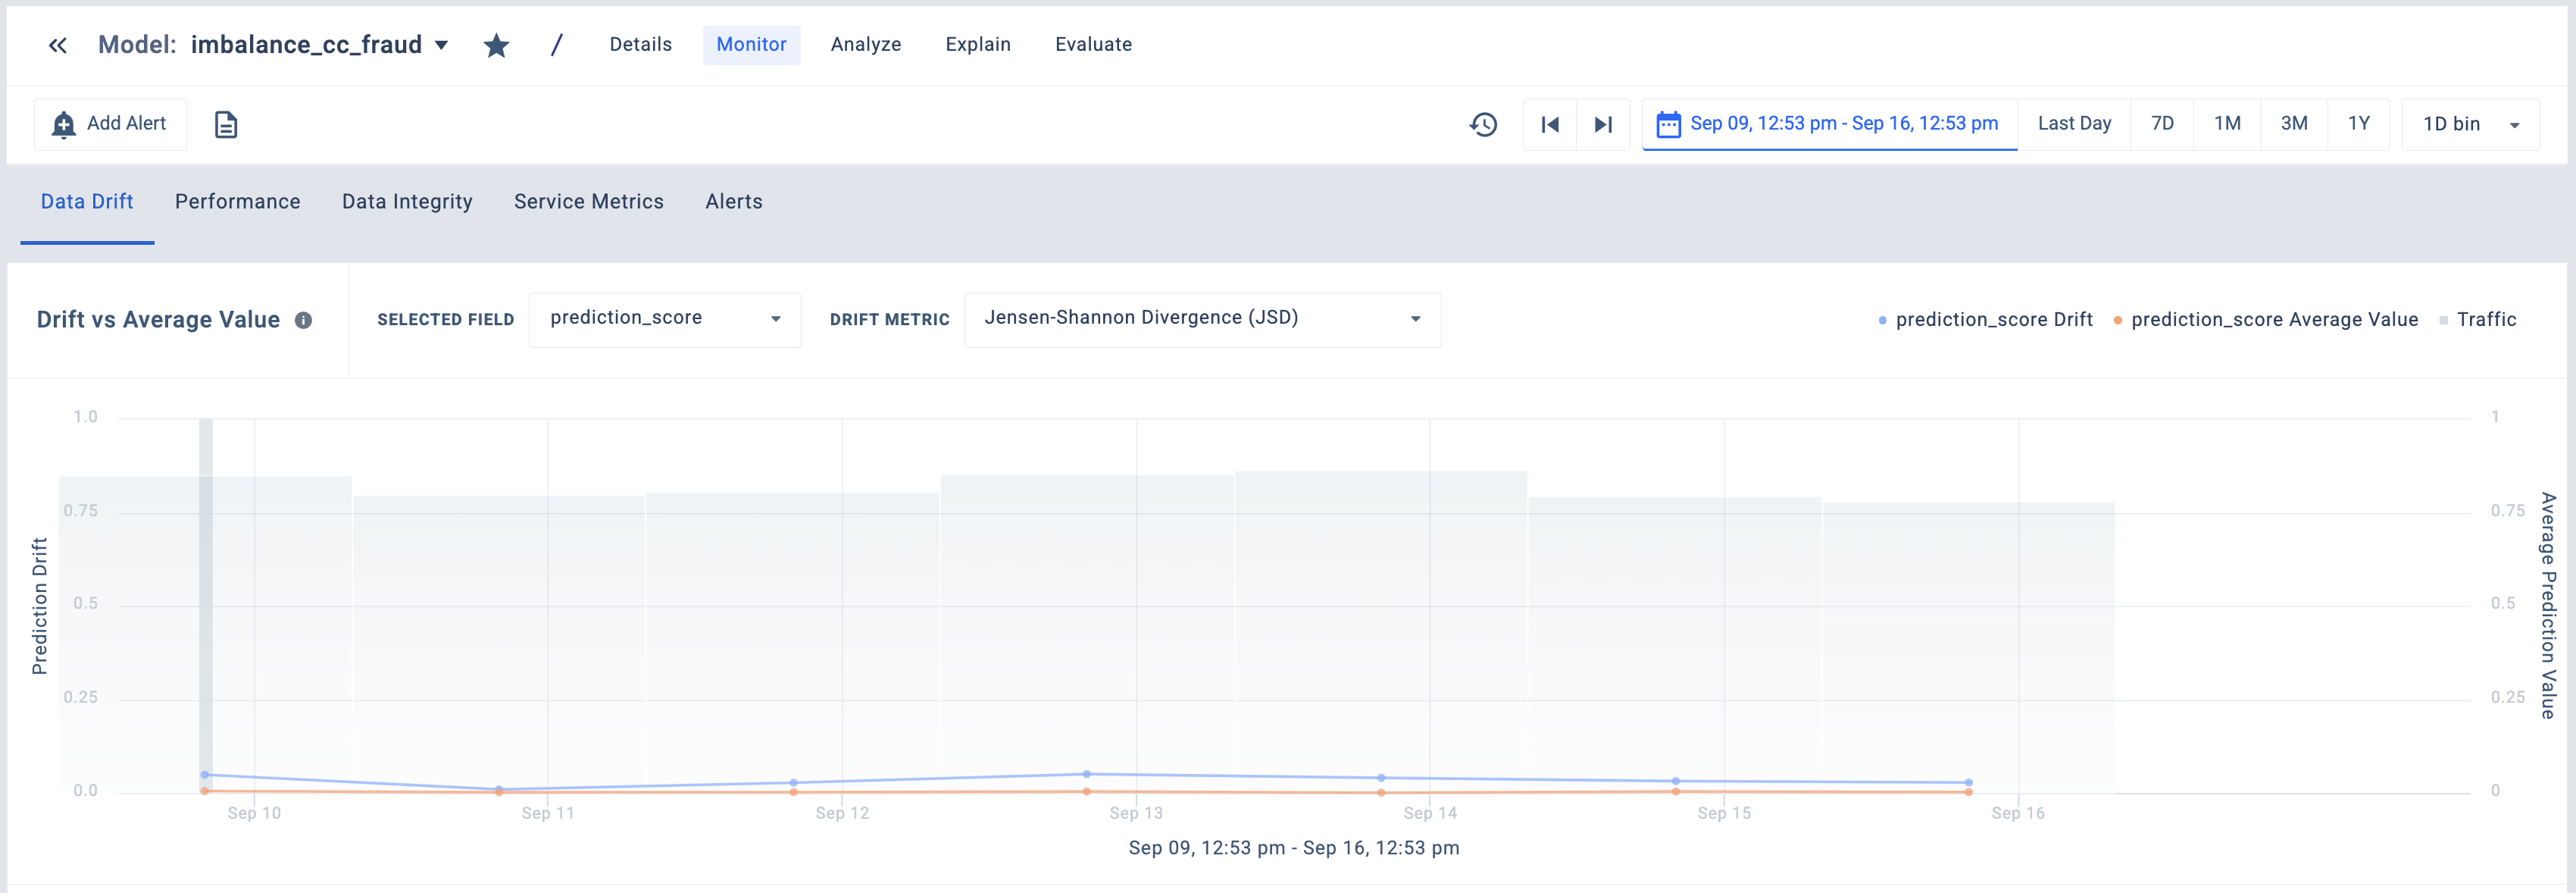

whereas, if we declare class weights then we see a higher drift which is more correct respresentation if the production data where the ratio of minority is class is 3x

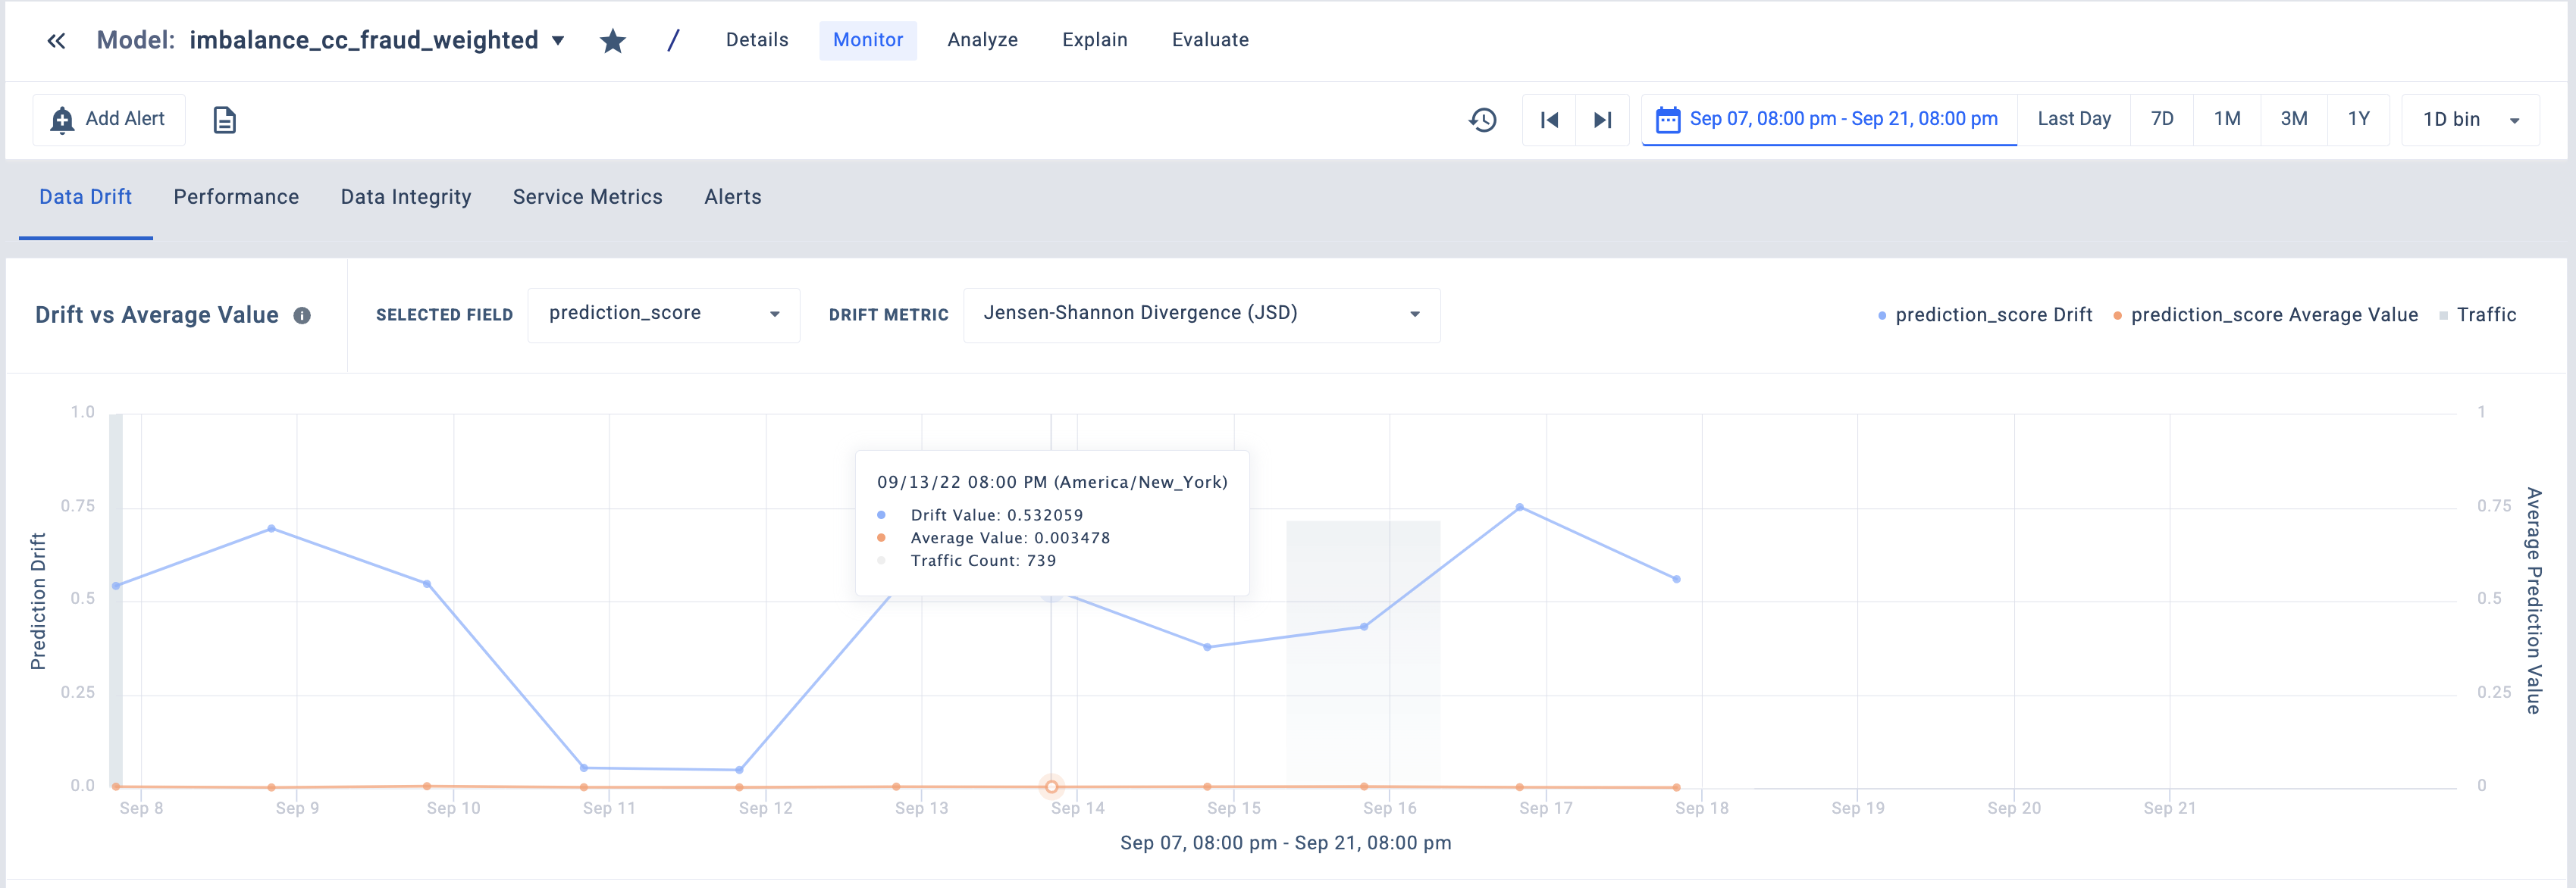



---


**Questions?**  
  
Check out [our docs](https://docs.fiddler.ai/) for a more detailed explanation of what Fiddler has to offer.

If you're still looking for answers, fill out a ticket on [our support page](https://fiddlerlabs.zendesk.com/) and we'll get back to you shortly.